Video
====

In [1]:
import numpy as np
import torch
torch.set_printoptions(edgeitems=2, threshold=50)

When it comes to the shape of tensors, video data can be seen as equivalent to volumetric data, with `depth` replaced by the `time` dimension. The result is again a 5D tensor with shape `N x C x T x H x W`.

There are several formats for video, especially geared towards compression by exploiting redundancies in space and time. Luckily for us, `imageio` reads video data as well. Suppose we'd like to retain 100 consecutive frames in our 512 x 512 RBG video for classifying an action using a convolutional neural network. We first create a reader instance for the video, that will allow us to get information about the video and iterate over the frames in time.
Let's see what the meta data for the video looks like:

In [2]:
!pip install youtube-dl

     |████████████████████████████████| 1.8MB 2.6MB/s 


In [4]:
!youtube-dl https://www.youtube.com/watch?v=vgAbqr3xXyw

[youtube] vgAbqr3xXyw: Downloading webpage
[youtube] vgAbqr3xXyw: Downloading MPD manifest
[dashsegments] Total fragments: 11
[download] Destination: Happy Sugar Life Love moment-vgAbqr3xXyw.f135.mp4
[download] 100% of 3.04MiB in 00:15
[dashsegments] Total fragments: 6
[download] Destination: Happy Sugar Life Love moment-vgAbqr3xXyw.f251.webm
[download] 100% of 801.56KiB in 00:04
[ffmpeg] Merging formats into "Happy Sugar Life Love moment-vgAbqr3xXyw.mkv"
Deleting original file Happy Sugar Life Love moment-vgAbqr3xXyw.f135.mp4 (pass -k to keep)
Deleting original file Happy Sugar Life Love moment-vgAbqr3xXyw.f251.webm (pass -k to keep)




```
{'plugin': 'ffmpeg',
 'nframes': 280,
 'ffmpeg_version': '4.1 built with gcc 8.2.1 (GCC) 20181017',
 'fps': 20.0,
 'source_size': (1280, 720),
 'size': (1280, 720),
 'duration': 14.0}
```



In [5]:
import imageio

reader = imageio.get_reader('/content/Happy Sugar Life Love moment-vgAbqr3xXyw.mkv')
meta = reader.get_meta_data()
meta

{'duration': 48.98,
 'ffmpeg_version': '3.4.8-0ubuntu0.2 built with gcc 7 (Ubuntu 7.5.0-3ubuntu1~18.04)',
 'fps': 30.0,
 'nframes': 1469,
 'plugin': 'ffmpeg',
 'size': (854, 478),
 'source_size': (854, 478)}

We now have all the information to size the tensor that will store the video frames:

In [6]:
n_channels = 3
n_frames = meta['nframes']
video = torch.empty(n_channels, n_frames, *meta['size'])

video.shape

torch.Size([3, 1469, 854, 478])

Now we just iterate over the reader and set the values for all three channels into in the proper `i`-th time slice.
This might take a few seconds to finish!

In [ ]:
for i, frame_arr in enumerate(reader):
    frame = torch.from_numpy(frame_arr).float()
    video[:, i] = torch.transpose(frame, 0, 2)

In [9]:
video.shape

torch.Size([3, 1469, 854, 478])

In the above, we iterate over individual frames and set each frame in the `C x T x H x W` video tensor, after transposing the channel. We can then obtain a batch by stacking multiple 4D tensors or pre-allocating a 5D tensor with a known batch size and filling it iteratively, clip by clip, assuming clips are trimmed to a fixed number of frames.

Equating video data to volumetric data is not the only way to represent video for training purposes. This is a valid strategy if we deal with video bursts of fixed length. An alternative strategy is to resort to network architectures capable of processing long sequences and exploiting short and long-term relationships in time, just like for text or audio.
// We'll see this kind of architectures when we take on recurrent networks.

This next approach accounts for time along the batch dimension. Hence, we'll build our dataset as a 4D tensor, stacking frame by frame in the batch:


In [10]:
video.shape

torch.Size([3, 1469, 854, 478])

In [11]:
#            torch.empty(n_channels, n_frames, *meta['size'])
time_video = torch.empty(n_frames, n_channels, *meta['size'])

for i, frame in enumerate(reader):
    frame = torch.from_numpy(frame).float()
    time_video[i] = torch.transpose(frame, 0, 2)

time_video.shape

torch.Size([1469, 3, 854, 478])

In [51]:
img1 = time_video[800]/255

In [13]:
from PIL import Image

In [17]:
import torchvision

In [52]:
img1.shape

torch.Size([3, 854, 478])

In [53]:
i1 = torchvision.transforms.ToPILImage()(img1)

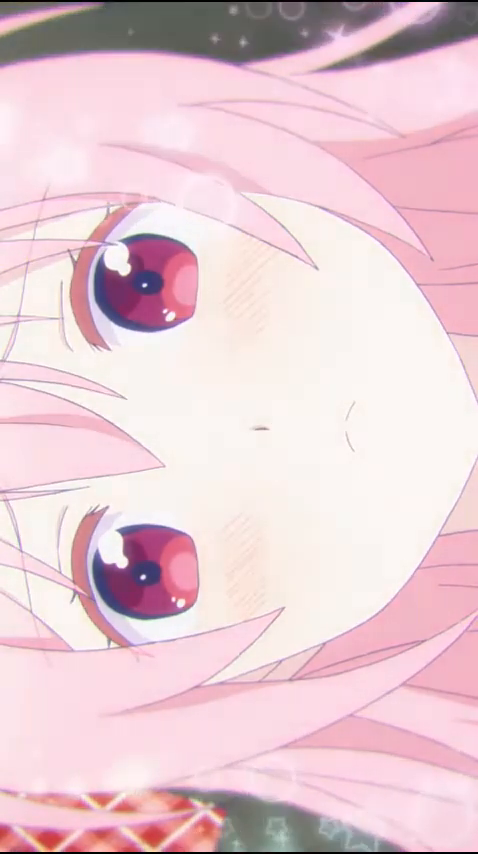

In [54]:
i1

In [20]:
img1

tensor([[[ 0.,  0.,  ...,  0.,  0.],
         [ 9.,  9.,  ...,  0.,  0.],
         ...,
         [ 0.,  0.,  ...,  0.,  0.],
         [ 0.,  0.,  ...,  0.,  0.]],

        [[ 5.,  5.,  ...,  0.,  0.],
         [14., 14.,  ...,  1.,  1.],
         ...,
         [ 1.,  1.,  ...,  2.,  2.],
         [ 1.,  1.,  ...,  0.,  0.]],

        [[25., 25.,  ..., 10., 10.],
         [34., 34.,  ..., 12., 12.],
         ...,
         [18., 18.,  ..., 15., 15.],
         [18., 18.,  ...,  9.,  9.]]])

In [59]:
from IPython.display import HTML
from base64 import b64encode
mp4 = open('/content/Happy Sugar Life Love moment-vgAbqr3xXyw.mkv','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)